In [205]:
import glob
import regex as re
import numpy as np
import pandas as pd
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import geopy
from geopy.distance import vincenty
from datetime import timedelta
%matplotlib inline

In [21]:
path = '../data'

In [10]:
stations = pd.read_csv(path+'/stations.csv')
targets = pd.read_csv(path+'/targets.csv')
headers_mod = pd.read_csv(path+'/headers_mod.csv')
headers_obs = pd.read_csv(path+'/headers_obs.csv')

## Build raw data

In [144]:
with open('../data/headers_mod.csv') as f:
    mod_headers = f.readlines()[0].split()
    
with open('../data/headers_obs.csv') as f:
    obs_headers = f.readlines()[0].split()
    
mod_headers, obs_headers

(['lon', 'lat', 'day', 'hour', 'AirPollutant', 'Concentration'],
 ['Countrycode',
  'Namespace',
  'AirQualityNetwork',
  'AirQualityStation',
  'AirQualityStationEoICode',
  'SamplingPoint',
  'SamplingProcess',
  'Sample',
  'AirPollutant',
  'AirPollutantCode',
  'AveragingTime',
  'Concentration',
  'UnitOfMeasurement',
  'DatetimeBegin',
  'DatetimeEnd',
  'Validity',
  'Verification'])

In [ ]:
observations = []
for folder in glob.glob('../data/obs/*'):
    for file in glob.glob('{}/*'.format(folder)):
        year = re.search('\d{4}', file)[0]
        station = 'ES{}A'.format(re.findall('\d{4}', file)[1])
        data = pd.read_csv(file, sep='\t', names=obs_headers)
        observations.append((year, station, data))
        
observations[0][2].sample(5)

In [30]:
obs_df = pd.DataFrame()
for obs in observations:
    obs_df = obs_df.append(obs[2]).reset_index(drop=True)

In [33]:
obs_df.to_csv(path+'/all_obs.csv')

In [145]:
models = []
for folder in glob.glob('../data/mod/*'):
    for file in glob.glob('{}/*'.format(folder)):
        year = re.search('\d{4}', file)[0]
        station = 'ES{}A'.format(re.findall('\d{4}', file)[-1])
        data = pd.read_table(file, sep='\s+', names=mod_headers)
        data['year'] = year
        data['station'] = station
        models.append(data)
        
models = pd.concat(models)
models.sample(5)

,lon,lat,day,hour,AirPollutant,Concentration,year,station
36,2.14799,41.4261,2015-08-15,12:00:00,NO2,9.58821,2015,ES1856A
33,2.15339,41.3987,2013-11-22,09:00:00,NO2,18.27000,2013,ES1480A
27,2.14799,41.4261,2014-12-18,03:00:00,NO2,37.06750,2014,ES1856A
46,2.15339,41.3987,2013-02-13,22:00:00,NO2,34.73870,2013,ES1480A
22,2.15382,41.3853,2015-01-28,22:00:00,NO2,77.99080,2015,ES1438A


In [146]:
models = models.reset_index(drop=True)

In [147]:
models.to_csv(path+'/all_models.csv')

## Feature engineering

### Dates

In [54]:
df_obs

,Countrycode,Namespace,AirQualityNetwork,AirQualityStation,AirQualityStationEoICode,SamplingPoint,SamplingProcess,Sample,AirPollutant,AirPollutantCode,AveragingTime,Concentration,UnitOfMeasurement,DatetimeBegin,DatetimeEnd,Validity,Verification,day,month,year
0,in/ES_8_2013-2015_timeseries.csv:ES,ES.BDCA.AQD,NET_ES209A,STA_ES1480A,ES1480A,SP_08019044_8_8,SPP_08019044_8_8.1,SAM_08019044_8_8,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,90,µg/m3,2013-07-05 18:00:00,2013-07-05 19:00:00,1,1,2013-07-05,7,2013
1,in/ES_8_2013-2015_timeseries.csv:ES,ES.BDCA.AQD,NET_ES209A,STA_ES1480A,ES1480A,SP_08019044_8_8,SPP_08019044_8_8.1,SAM_08019044_8_8,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,87,µg/m3,2013-07-05 19:00:00,2013-07-05 20:00:00,1,1,2013-07-05,7,2013
2,in/ES_8_2013-2015_timeseries.csv:ES,ES.BDCA.AQD,NET_ES209A,STA_ES1480A,ES1480A,SP_08019044_8_8,SPP_08019044_8_8.1,SAM_08019044_8_8,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,76,µg/m3,2013-07-05 20:00:00,2013-07-05 21:00:00,1,1,2013-07-05,7,2013
3,in/ES_8_2013-2015_timeseries.csv:ES,ES.BDCA.AQD,NET_ES209A,STA_ES1480A,ES1480A,SP_08019044_8_8,SPP_08019044_8_8.1,SAM_08019044_8_8,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,65,µg/m3,2013-07-05 21:00:00,2013-07-05 22:00:00,1,1,2013-07-05,7,2013
4,in/ES_8_2013-2015_timeseries.csv:ES,ES.BDCA.AQD,NET_ES209A,STA_ES1480A,ES1480A,SP_08019044_8_8,SPP_08019044_8_8.1,SAM_08019044_8_8,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,56,µg/m3,2013-07-05 22:00:00,2013-07-05 23:00:00,1,1,2013-07-05,7,2013
5,in/ES_8_2013-2015_timeseries.csv:ES,ES.BDCA.AQD,NET_ES209A,STA_ES1480A,ES1480A,SP_08019044_8_8,SPP_08019044_8_8.1,SAM_08019044_8_8,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,66,µg/m3,2013-07-05 23:00:00,2013-07-06 00:00:00,1,1,2013-07-05,7,2013
6,in/ES_8_2013-2015_timeseries.csv:ES,ES.BDCA.AQD,NET_ES209A,STA_ES1480A,ES1480A,SP_08019044_8_8,SPP_08019044_8_8.1,SAM_08019044_8_8,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,87,µg/m3,2013-07-06 00:00:00,2013-07-06 01:00:00,1,1,2013-07-06,7,2013
7,in/ES_8_2013-2015_timeseries.csv:ES,ES.BDCA.AQD,NET_ES209A,STA_ES1480A,ES1480A,SP_08019044_8_8,SPP_08019044_8_8.1,SAM_08019044_8_8,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,92,µg/m3,2013-07-06 01:00:00,2013-07-06 02:00:00,1,1,2013-07-06,7,2013
8,in/ES_8_2013-2015_timeseries.csv:ES,ES.BDCA.AQD,NET_ES209A,STA_ES1480A,ES1480A,SP_08019044_8_8,SPP_08019044_8_8.1,SAM_08019044_8_8,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,93,µg/m3,2013-07-06 02:00:00,2013-07-06 03:00:00,1,1,2013-07-06,7,2013
9,in/ES_8_2013-2015_timeseries.csv:ES,ES.BDCA.AQD,NET_ES209A,STA_ES1480A,ES1480A,SP_08019044_8_8,SPP_08019044_8_8.1,SAM_08019044_8_8,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,85,µg/m3,2013-07-06 03:00:00,2013-07-06 04:00:00,1,1,2013-07-06,7,2013


In [126]:
df_obs['DatetimeBegin'] = pd.to_datetime(df_obs['DatetimeBegin'])
df_obs['DatetimeEnd'] = pd.to_datetime(df_obs['DatetimeEnd'])
df_obs['date'] = df_obs['DatetimeBegin'].dt.date
df_obs = df_obs.rename(columns={'AirQualityStationEoICode': 'station'})

In [ ]:
def gen_dates_feat(data):
    daily_targets = data.groupby(by=['date', 'station'])['Concentration'].max().reset_index()
    daily_targets = daily_targets.rename(columns={'Concentration': 'concentration'})
    all_dates = pd.DataFrame({'date': daily_targets['date'].unique()})
    all_stations = pd.DataFrame()
    for station in stations['station'].unique():
        temp = all_dates.join(daily_targets.loc[daily_targets['station'] == station].set_index('date'), on='date', how='left')
        temp.loc[:,'station'] = station
        all_stations = all_stations.append(temp).reset_index(drop=True)
    daily_targets = all_stations
    daily_targets['target'] = 0
    daily_targets.loc[daily_targets['concentration'] > 100, 'target'] = 1
    daily_targets['date'] = pd.to_datetime(daily_targets['date'])
    daily_targets['year'] = daily_targets['date'].dt.year
    daily_targets['month'] = daily_targets['date'].dt.month
    daily_targets['week_day'] = daily_targets['date'].dt.dayofweek
    daily_targets['day'] = daily_targets['date'].dt.day
    daily_targets['weekend'] = 0
    daily_targets.loc[daily_targets['week_day']>4, 'weekend'] = 1
    daily_targets['holiday'] = 0
    holidays.apply(add_holidays, axis = 1)
    daily_targets.loc[daily_targets['week_day']>4, 'holiday'] = 1
    daily_targets = daily_targets.ffill()
    for year in [2013, 2014, 2015]:
        daily_targets.loc[(daily_targets['date'] >= datetime.date(year-1, 12, 21)) & 
                          (daily_targets['date'] <= datetime.date(year, 3, 20)), 'season'] = 0
        daily_targets.loc[(daily_targets['date'] >= datetime.date(year, 3, 21)) &
                          (daily_targets['date'] <= datetime.date(year, 6, 20)), 'season'] = 1
        daily_targets.loc[(daily_targets['date'] >= datetime.date(year, 6, 21)) &
                          (daily_targets['date'] <= datetime.date(year, 9, 20)), 'season'] = 2
        daily_targets.loc[(daily_targets['date'] >= datetime.date(year, 9, 21)) &
                          (daily_targets['date'] <= datetime.date(year, 12, 20)), 'season'] = 3
        daily_targets.loc[(daily_targets['date'] >= datetime.date(year, 12, 21)) &
                          (daily_targets['date'] <= datetime.date(year+1, 3, 20)), 'season'] = 0
    daily_targets = daily_targets.join(create_ts_df(daily_targets, 'date').set_index('date'), on='date', how='left')
    cols = list(daily_targets.filter(regex='ES').columns)
    cols_no_lagg = ['date', 'target', 'month', 'week_day', 'weekend', 'holiday', 'station', 'concentration', 'season']
    daily_targets = create_model_matrix(daily_targets, cols, cols_no_lagg).dropna().reset_index(drop=True)
    daily_targets = daily_targets.join(stations.set_index('station').filter(regex='dist_to'), on='station', how='left')
    return daily_targets

In [550]:
daily_targets = df_obs.groupby(by=['date', 'station'])['Concentration'].max().reset_index()
daily_targets = daily_targets.rename(columns={'Concentration': 'concentration'})
all_dates = pd.DataFrame({'date': daily_targets['date'].unique()})
all_stations = pd.DataFrame()
for station in stations['station'].unique():
    temp = all_dates.join(daily_targets.loc[daily_targets['station'] == station].set_index('date'), on='date', how='left')
    temp.loc[:,'station'] = station
    all_stations = all_stations.append(temp).reset_index(drop=True)
daily_targets = all_stations
daily_targets['target'] = 0
daily_targets.loc[daily_targets['concentration'] > 100, 'target'] = 1

In [551]:
daily_targets[daily_targets['target'] == 1]

,date,station,concentration,target
2,2013-01-03,ES1480A,102.0,1
3,2013-01-04,ES1480A,187.0,1
4,2013-01-05,ES1480A,131.0,1
6,2013-01-07,ES1480A,182.0,1
7,2013-01-08,ES1480A,112.0,1
9,2013-01-10,ES1480A,107.0,1
15,2013-01-16,ES1480A,112.0,1
23,2013-01-24,ES1480A,111.0,1
24,2013-01-25,ES1480A,109.0,1
29,2013-01-30,ES1480A,120.0,1


In [552]:
len(daily_targets[daily_targets['target'] == 1]) / len(daily_targets) * 100

19.360516280434144

In [553]:
len(daily_targets[daily_targets['target'] == 1])

1320

In [554]:
dias = [1, 29, 1, 1, 20, 24, 15, 11, 24, 12, 1, 6, 25, 26, 
        1, 6, 18, 21, 1, 9, 24, 15, 11, 24, 1, 6, 8, 25, 26,
        1, 6, 3, 6, 1, 1, 24, 15, 11, 24, 12, 8, 25, 26]
mes = [1, 3, 4, 5, 5, 6, 8, 9, 9, 10, 11, 12, 12, 12, 
       1, 1, 4, 4, 5, 6, 6, 8, 9, 9, 11, 12, 12, 12, 12,
       1, 1, 4, 4, 5, 6, 6, 8, 9, 9, 10, 12, 12, 12]
       
años = [2013] * 14 + [2014] * 15 + [2015] * 14

holidays = pd.DataFrame({'day': dias, 'month': mes, 'year': años})

In [592]:
def add_holidays(row, data):
    data.loc[(data['day'] == row['day']) & 
             (data['month'] == row['month']) & 
             (data['year'] == row['year']), 'holiday'] = 1

In [556]:
daily_targets['date'] = pd.to_datetime(daily_targets['date'])
daily_targets['year'] = daily_targets['date'].dt.year
daily_targets['month'] = daily_targets['date'].dt.month
daily_targets['week_day'] = daily_targets['date'].dt.dayofweek
daily_targets['day'] = daily_targets['date'].dt.day
daily_targets['weekend'] = 0
daily_targets.loc[daily_targets['week_day']>4, 'weekend'] = 1
daily_targets['holiday'] = 0
holidays.apply(add_holidays, axis = 1)
daily_targets.loc[daily_targets['week_day']>4, 'holiday'] = 1

In [557]:
daily_targets = daily_targets.ffill()

In [558]:
for year in [2013, 2014, 2015]:
    daily_targets.loc[(daily_targets['date'] >= datetime.date(year-1, 12, 21)) & 
                      (daily_targets['date'] <= datetime.date(year, 3, 20)), 'season'] = 0
    daily_targets.loc[(daily_targets['date'] >= datetime.date(year, 3, 21)) &
                      (daily_targets['date'] <= datetime.date(year, 6, 20)), 'season'] = 1
    daily_targets.loc[(daily_targets['date'] >= datetime.date(year, 6, 21)) &
                      (daily_targets['date'] <= datetime.date(year, 9, 20)), 'season'] = 2
    daily_targets.loc[(daily_targets['date'] >= datetime.date(year, 9, 21)) &
                      (daily_targets['date'] <= datetime.date(year, 12, 20)), 'season'] = 3
    daily_targets.loc[(daily_targets['date'] >= datetime.date(year, 12, 21)) &
                      (daily_targets['date'] <= datetime.date(year+1, 3, 20)), 'season'] = 0

In [313]:
def create_lagged_features(data, lags):
    '''
    This function takes a time series and
    returns a dataframe with <lags>
    1-to-lag lagged features.
    '''
    data_list = []
    for lag in range(1, lags+1):
        shifted_data = data.shift(lag)
        col_dict = {}
        for col in data.columns:
            col_dict[col] = col+'_lag_'+str(lag)

        shifted_data = shifted_data.rename(columns=col_dict)
        data_list.append(shifted_data)
    data = pd.concat(data_list, axis=1)
    return data

def create_model_matrix(data, lagged_cols=[], no_lagged_cols=[], lags=2):
    '''Pass features and target as dataframes.'''
    lagged_data = create_lagged_features(data[lagged_cols], lags)
    no_lagged_data = data[no_lagged_cols]
    if no_lagged_cols:
        model_matrix = pd.concat([lagged_data, no_lagged_data], axis=1)
    else:
        model_matrix = lagged_data
    return model_matrix

In [404]:
def create_ts_df(data, date_col='date'):
    new_data = pd.DataFrame()
    for station in data['station'].unique():
        new_data[station] = data.loc[data['station'] ==\
                station, 'concentration'].reset_index(drop=True)
        new_data[date_col] = data.loc[data['station'] == station, date_col].reset_index(drop=True)

    return new_data

In [559]:
daily_targets = daily_targets.join(create_ts_df(daily_targets, 'date').set_index('date'), on='date', how='left')

In [560]:
cols = list(daily_targets.filter(regex='ES').columns)
cols_no_lagg = ['date', 'target', 'month', 'week_day', 'weekend', 'holiday', 'station', 'concentration', 'season']

In [561]:
daily_targets = create_model_matrix(daily_targets, cols, cols_no_lagg).dropna().reset_index(drop=True)

In [562]:
daily_targets = daily_targets.join(stations.set_index('station').filter(regex='dist_to'), on='station', how='left')

In [563]:
daily_targets.to_csv(path+'/dataset_v1.csv')

In [564]:
list(daily_targets.columns)

['ES1480A_lag_1',
 'ES1856A_lag_1',
 'ES1679A_lag_1',
 'ES1438A_lag_1',
 'ES1396A_lag_1',
 'ES1992A_lag_1',
 'ES0691A_lag_1',
 'ES1480A_lag_2',
 'ES1856A_lag_2',
 'ES1679A_lag_2',
 'ES1438A_lag_2',
 'ES1396A_lag_2',
 'ES1992A_lag_2',
 'ES0691A_lag_2',
 'date',
 'target',
 'month',
 'week_day',
 'weekend',
 'holiday',
 'station',
 'concentration',
 'season',
 'dist_to_ES0691A',
 'dist_to_ES1480A',
 'dist_to_ES1856A',
 'dist_to_ES1679A',
 'dist_to_ES1438A',
 'dist_to_ES1396A',
 'dist_to_ES1992A']

### Distances

In [197]:
station = stations.rename(columns={'code': 'station'})

In [192]:
for st in stations['code']:
    stations['dist_to_'+st] = 0
    for i in stations.index:
        dist = vincenty((stations.loc[i,'lat'],stations.loc[i,'lon']), 
                        (stations[stations['code'] == st]['lat'].iloc[0], 
                         stations[stations['code'] == st]['lon'].iloc[0]))
        stations.loc[i, 'dist_to_'+st] = dist.km
        

In [567]:
daily_targets[['date', 'weekend', 'holiday', 'month', 'week_day', 'season']].to_csv(path+'/dates_processed.csv')

In [539]:
stations.to_csv(path+'/stations_processed.csv')

### Feats

In [202]:
data_roll_day_conc_obs = pd.read_csv(path+'/data_roll_day_conc_obs.csv')

In [ ]:
['mean', 'median', 'sd', 'min', 'max', 'p10', 'p25', 'p75', 'p90', ]

In [206]:
list(data_roll_day_conc_obs.columns)

['station',
 'date',
 'max_conc_obs',
 'max_conc_models_mean',
 'max_conc_obs_mean_2',
 'max_conc_models_mean_mean_2',
 'max_conc_obs_mean_3',
 'max_conc_models_mean_mean_3',
 'max_conc_obs_mean_4',
 'max_conc_models_mean_mean_4',
 'max_conc_obs_mean_5',
 'max_conc_models_mean_mean_5',
 'max_conc_obs_mean_6',
 'max_conc_models_mean_mean_6',
 'max_conc_obs_mean_7',
 'max_conc_models_mean_mean_7',
 'max_conc_obs_mean_8',
 'max_conc_models_mean_mean_8',
 'max_conc_obs_mean_9',
 'max_conc_models_mean_mean_9',
 'max_conc_obs_mean_10',
 'max_conc_models_mean_mean_10',
 'max_conc_obs_mean_11',
 'max_conc_models_mean_mean_11',
 'max_conc_obs_mean_12',
 'max_conc_models_mean_mean_12',
 'max_conc_obs_mean_13',
 'max_conc_models_mean_mean_13',
 'max_conc_obs_mean_14',
 'max_conc_models_mean_mean_14',
 'max_conc_obs_mean_15',
 'max_conc_models_mean_mean_15',
 'max_conc_obs_mean_16',
 'max_conc_models_mean_mean_16',
 'max_conc_obs_mean_17',
 'max_conc_models_mean_mean_17',
 'max_conc_obs_mean_18',


In [493]:
import xgboost as xgb
from sklearn.metrics import log_loss

In [463]:
model = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', 
                         booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                         subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                         scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None)

In [468]:
daily_targets = pd.get_dummies(daily_targets, columns=['station'])

In [472]:
cols = list(daily_targets.filter(regex='ES').columns)
cols += ['weekend', 'holiday', 'month', 'week_day']

In [476]:
daily_targets.columns

Index(['ES0691A_lag_1', 'ES1396A_lag_1', 'ES1438A_lag_1', 'ES1480A_lag_1',
       'ES1679A_lag_1', 'ES1856A_lag_1', 'ES1992A_lag_1', 'ES0691A_lag_2',
       'ES1396A_lag_2', 'ES1438A_lag_2', 'ES1480A_lag_2', 'ES1679A_lag_2',
       'ES1856A_lag_2', 'ES1992A_lag_2', 'date', 'target', 'month', 'week_day',
       'weekend', 'holiday', 'concentration', 'dist_to_ES0691A',
       'dist_to_ES1480A', 'dist_to_ES1856A', 'dist_to_ES1679A',
       'dist_to_ES1438A', 'dist_to_ES1396A', 'dist_to_ES1992A',
       'station_ES0691A', 'station_ES1396A', 'station_ES1438A',
       'station_ES1480A', 'station_ES1679A', 'station_ES1856A',
       'station_ES1992A'],
      dtype='object')

In [504]:
train = daily_targets[daily_targets['date'] < datetime.date(2015,1,1)]
test = daily_targets[daily_targets['date'] >= datetime.date(2014,6,1)]

In [505]:
model.fit(train[cols], train['concentration'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [519]:
pred = model.predict(test[cols])

In [521]:
feat_importance = pd.DataFrame({'feature': cols, 'importance':model.feature_importances_})

In [536]:
feat_importance.sort_values('importance', ascending=False)

,feature,importance
0,ES0691A_lag_1,0.102750
8,ES1396A_lag_2,0.078148
1,ES1396A_lag_1,0.065123
10,ES1480A_lag_2,0.059334
9,ES1438A_lag_2,0.054993
29,holiday,0.054993
15,dist_to_ES1480A,0.053546
2,ES1438A_lag_1,0.052098
3,ES1480A_lag_1,0.050651
7,ES0691A_lag_2,0.050651


In [ ]:
pred = model.predict(data.loc[data['date'] == date, cols_fit])
data.loc[data['date'] == date, 'concentracion'] = pred

In [518]:
list(daily_targets.columns)

['ES0691A_lag_1',
 'ES1396A_lag_1',
 'ES1438A_lag_1',
 'ES1480A_lag_1',
 'ES1679A_lag_1',
 'ES1856A_lag_1',
 'ES1992A_lag_1',
 'ES0691A_lag_2',
 'ES1396A_lag_2',
 'ES1438A_lag_2',
 'ES1480A_lag_2',
 'ES1679A_lag_2',
 'ES1856A_lag_2',
 'ES1992A_lag_2',
 'date',
 'target',
 'month',
 'week_day',
 'weekend',
 'holiday',
 'concentration',
 'dist_to_ES0691A',
 'dist_to_ES1480A',
 'dist_to_ES1856A',
 'dist_to_ES1679A',
 'dist_to_ES1438A',
 'dist_to_ES1396A',
 'dist_to_ES1992A',
 'station_ES0691A',
 'station_ES1396A',
 'station_ES1438A',
 'station_ES1480A',
 'station_ES1679A',
 'station_ES1856A',
 'station_ES1992A']

In [570]:
data = daily_targets

In [572]:
data

,ES1480A_lag_1,ES1856A_lag_1,ES1679A_lag_1,ES1438A_lag_1,ES1396A_lag_1,ES1992A_lag_1,ES0691A_lag_1,ES1480A_lag_2,ES1856A_lag_2,ES1679A_lag_2,...,station,concentration,season,dist_to_ES0691A,dist_to_ES1480A,dist_to_ES1856A,dist_to_ES1679A,dist_to_ES1438A,dist_to_ES1396A,dist_to_ES1992A
0,79.0,77.0,76.0,119.0,86.0,85.0,87.0,94.0,39.0,69.0,...,ES1480A,102.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
1,102.0,94.0,78.0,117.0,85.0,110.0,119.0,79.0,77.0,76.0,...,ES1480A,187.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
2,187.0,60.0,108.0,123.0,113.0,99.0,80.0,102.0,94.0,78.0,...,ES1480A,131.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
3,131.0,16.0,114.0,123.0,114.0,85.0,60.0,187.0,60.0,108.0,...,ES1480A,95.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
4,95.0,76.0,86.0,123.0,91.0,112.0,91.0,131.0,16.0,114.0,...,ES1480A,182.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
5,182.0,103.0,126.0,123.0,110.0,95.0,79.0,95.0,76.0,86.0,...,ES1480A,112.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
6,112.0,115.0,96.0,123.0,103.0,105.0,92.0,182.0,103.0,126.0,...,ES1480A,86.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
7,86.0,65.0,90.0,111.0,53.0,59.0,71.0,112.0,115.0,96.0,...,ES1480A,107.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
8,107.0,98.0,89.0,146.0,119.0,104.0,96.0,86.0,65.0,90.0,...,ES1480A,92.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
9,92.0,70.0,100.0,121.0,99.0,95.0,96.0,107.0,98.0,89.0,...,ES1480A,89.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523


In [573]:
data.loc[data['station'] == station].set_index('date')

,ES1480A_lag_1,ES1856A_lag_1,ES1679A_lag_1,ES1438A_lag_1,ES1396A_lag_1,ES1992A_lag_1,ES0691A_lag_1,ES1480A_lag_2,ES1856A_lag_2,ES1679A_lag_2,...,station,concentration,season,dist_to_ES0691A,dist_to_ES1480A,dist_to_ES1856A,dist_to_ES1679A,dist_to_ES1438A,dist_to_ES1396A,dist_to_ES1992A
date,,,,,,,,,,,,,,,,,,,,,
2013-01-03,79.0,77.0,76.0,119.0,86.0,85.0,87.0,94.0,39.0,69.0,...,ES1480A,102.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523
2013-01-04,102.0,94.0,78.0,117.0,85.0,110.0,119.0,79.0,77.0,76.0,...,ES1480A,187.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523
2013-01-05,187.0,60.0,108.0,123.0,113.0,99.0,80.0,102.0,94.0,78.0,...,ES1480A,131.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523
2013-01-06,131.0,16.0,114.0,123.0,114.0,85.0,60.0,187.0,60.0,108.0,...,ES1480A,95.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523
2013-01-07,95.0,76.0,86.0,123.0,91.0,112.0,91.0,131.0,16.0,114.0,...,ES1480A,182.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523
2013-01-08,182.0,103.0,126.0,123.0,110.0,95.0,79.0,95.0,76.0,86.0,...,ES1480A,112.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523
2013-01-09,112.0,115.0,96.0,123.0,103.0,105.0,92.0,182.0,103.0,126.0,...,ES1480A,86.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523
2013-01-10,86.0,65.0,90.0,111.0,53.0,59.0,71.0,112.0,115.0,96.0,...,ES1480A,107.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523
2013-01-11,107.0,98.0,89.0,146.0,119.0,104.0,96.0,86.0,65.0,90.0,...,ES1480A,92.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523


In [575]:
data

,ES1480A_lag_1,ES1856A_lag_1,ES1679A_lag_1,ES1438A_lag_1,ES1396A_lag_1,ES1992A_lag_1,ES0691A_lag_1,ES1480A_lag_2,ES1856A_lag_2,ES1679A_lag_2,...,station,concentration,season,dist_to_ES0691A,dist_to_ES1480A,dist_to_ES1856A,dist_to_ES1679A,dist_to_ES1438A,dist_to_ES1396A,dist_to_ES1992A
0,79.0,77.0,76.0,119.0,86.0,85.0,87.0,94.0,39.0,69.0,...,ES1480A,102.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
1,102.0,94.0,78.0,117.0,85.0,110.0,119.0,79.0,77.0,76.0,...,ES1480A,187.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
2,187.0,60.0,108.0,123.0,113.0,99.0,80.0,102.0,94.0,78.0,...,ES1480A,131.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
3,131.0,16.0,114.0,123.0,114.0,85.0,60.0,187.0,60.0,108.0,...,ES1480A,95.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
4,95.0,76.0,86.0,123.0,91.0,112.0,91.0,131.0,16.0,114.0,...,ES1480A,182.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
5,182.0,103.0,126.0,123.0,110.0,95.0,79.0,95.0,76.0,86.0,...,ES1480A,112.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
6,112.0,115.0,96.0,123.0,103.0,105.0,92.0,182.0,103.0,126.0,...,ES1480A,86.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
7,86.0,65.0,90.0,111.0,53.0,59.0,71.0,112.0,115.0,96.0,...,ES1480A,107.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
8,107.0,98.0,89.0,146.0,119.0,104.0,96.0,86.0,65.0,90.0,...,ES1480A,92.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523
9,92.0,70.0,100.0,121.0,99.0,95.0,96.0,107.0,98.0,89.0,...,ES1480A,89.0,0.0,4.314462,0.000000,3.076406,3.156929,1.488658,2.786497,3.431523


In [577]:
data.loc[data['station'] == station].set_index('date')

,ES1480A_lag_1,ES1856A_lag_1,ES1679A_lag_1,ES1438A_lag_1,ES1396A_lag_1,ES1992A_lag_1,ES0691A_lag_1,ES1480A_lag_2,ES1856A_lag_2,ES1679A_lag_2,...,station,concentration,season,dist_to_ES0691A,dist_to_ES1480A,dist_to_ES1856A,dist_to_ES1679A,dist_to_ES1438A,dist_to_ES1396A,dist_to_ES1992A
date,,,,,,,,,,,,,,,,,,,,,
2013-01-03,79.0,77.0,76.0,119.0,86.0,85.0,87.0,94.0,39.0,69.0,...,ES1480A,102.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523
2013-01-04,102.0,94.0,78.0,117.0,85.0,110.0,119.0,79.0,77.0,76.0,...,ES1480A,187.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523
2013-01-05,187.0,60.0,108.0,123.0,113.0,99.0,80.0,102.0,94.0,78.0,...,ES1480A,131.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523
2013-01-06,131.0,16.0,114.0,123.0,114.0,85.0,60.0,187.0,60.0,108.0,...,ES1480A,95.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523
2013-01-07,95.0,76.0,86.0,123.0,91.0,112.0,91.0,131.0,16.0,114.0,...,ES1480A,182.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523
2013-01-08,182.0,103.0,126.0,123.0,110.0,95.0,79.0,95.0,76.0,86.0,...,ES1480A,112.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523
2013-01-09,112.0,115.0,96.0,123.0,103.0,105.0,92.0,182.0,103.0,126.0,...,ES1480A,86.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523
2013-01-10,86.0,65.0,90.0,111.0,53.0,59.0,71.0,112.0,115.0,96.0,...,ES1480A,107.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523
2013-01-11,107.0,98.0,89.0,146.0,119.0,104.0,96.0,86.0,65.0,90.0,...,ES1480A,92.0,0.0,4.314462,0.0,3.076406,3.156929,1.488658,2.786497,3.431523


In [571]:
delta = datetime.date(2015, 12, 31) - datetime.date(2015, 1, 1)         # timedelta
all_dates = []
for i in range(delta.days + 1):
    all_dates += [datetime.date(2015, 1, 1) + timedelta(days=i)]

all_dates = pd.DataFrame({'date': all_dates})
all_stations = pd.DataFrame()
for station in data['station'].unique():
    temp = all_dates.join(data.loc[data['station'] == station].set_index('date'), on='date', how='left')
    temp.loc[:,'station'] = station
    all_stations = all_stations.append(temp).reset_index(drop=True)
data = all_stations

TypeError: Argument 'values' has incorrect type (expected numpy.ndarray, got Index)

In [531]:
all_dates

,date
0,2015-01-01
1,2015-01-02
2,2015-01-03
3,2015-01-04
4,2015-01-05
5,2015-01-06
6,2015-01-07
7,2015-01-08
8,2015-01-09
9,2015-01-10


In [541]:
daily_targets.columns

Index(['ES0691A_lag_1', 'ES1396A_lag_1', 'ES1438A_lag_1', 'ES1480A_lag_1',
       'ES1679A_lag_1', 'ES1856A_lag_1', 'ES1992A_lag_1', 'ES0691A_lag_2',
       'ES1396A_lag_2', 'ES1438A_lag_2', 'ES1480A_lag_2', 'ES1679A_lag_2',
       'ES1856A_lag_2', 'ES1992A_lag_2', 'date', 'target', 'month', 'week_day',
       'weekend', 'holiday', 'concentration', 'dist_to_ES0691A',
       'dist_to_ES1480A', 'dist_to_ES1856A', 'dist_to_ES1679A',
       'dist_to_ES1438A', 'dist_to_ES1396A', 'dist_to_ES1992A',
       'station_ES0691A', 'station_ES1396A', 'station_ES1438A',
       'station_ES1480A', 'station_ES1679A', 'station_ES1856A',
       'station_ES1992A'],
      dtype='object')

In [ ]:
date = datetime.date(2015,1,3)

data

In [517]:
daily_targets.loc[(daily_targets['date'] >=datetime.date(2015,1,1)) & (daily_targets['station_ES0691A'] == 1)]

,ES0691A_lag_1,ES1396A_lag_1,ES1438A_lag_1,ES1480A_lag_1,ES1679A_lag_1,ES1856A_lag_1,ES1992A_lag_1,ES0691A_lag_2,ES1396A_lag_2,ES1438A_lag_2,...,dist_to_ES1438A,dist_to_ES1396A,dist_to_ES1992A,station_ES0691A,station_ES1396A,station_ES1438A,station_ES1480A,station_ES1679A,station_ES1856A,station_ES1992A
728,103.0,76.0,133.0,116.0,101.0,90.0,78.0,75.0,57.0,77.0,...,4.716551,6.591714,7.692749,1,0,0,0,0,0,0
729,94.0,62.0,105.0,86.0,85.0,54.0,62.0,103.0,76.0,133.0,...,4.716551,6.591714,7.692749,1,0,0,0,0,0,0
730,121.0,98.0,178.0,147.0,105.0,90.0,91.0,94.0,62.0,105.0,...,4.716551,6.591714,7.692749,1,0,0,0,0,0,0
731,77.0,102.0,119.0,115.0,81.0,79.0,69.0,121.0,98.0,178.0,...,4.716551,6.591714,7.692749,1,0,0,0,0,0,0
732,80.0,102.0,117.0,140.0,73.0,94.0,131.0,77.0,102.0,119.0,...,4.716551,6.591714,7.692749,1,0,0,0,0,0,0
733,120.0,117.0,125.0,115.0,105.0,101.0,130.0,80.0,102.0,117.0,...,4.716551,6.591714,7.692749,1,0,0,0,0,0,0
734,61.0,102.0,87.0,139.0,81.0,56.0,135.0,120.0,117.0,125.0,...,4.716551,6.591714,7.692749,1,0,0,0,0,0,0
735,103.0,77.0,117.0,118.0,81.0,66.0,76.0,61.0,102.0,87.0,...,4.716551,6.591714,7.692749,1,0,0,0,0,0,0
736,70.0,96.0,135.0,111.0,74.0,79.0,106.0,103.0,77.0,117.0,...,4.716551,6.591714,7.692749,1,0,0,0,0,0,0
737,95.0,96.0,102.0,109.0,102.0,111.0,113.0,70.0,96.0,135.0,...,4.716551,6.591714,7.692749,1,0,0,0,0,0,0


In [513]:
def roll_agg(data, model, window, date, cols_fit, ops):
    pred = model.predict(data.loc[data['date'] == date, cols_fit])
    return pred
    #data.loc[data['date'] == date, 'concentration'] = pred
    #cond = (data['date'] > date - timedelta(days=window)) & (data['date'] <= date)
    #group_op = data.loc[cond].groupby(by='station')['Concentration'].agg(ops)
    #ops = ['sd' if (op =='std') else op for op in ops]
    #cols = ['max_conc_obs_'+op+'_'+str(window) for op in ops]
    #data.loc[data['date'] == date, cols] = group_op.values

In [514]:
roll_agg(daily_targets, model, 5, datetime.date(2015,1,3), cols, ops)

array([], dtype=float32)

In [509]:
targets['date']

0      2015-01-03
1      2015-01-03
2      2015-01-03
3      2015-01-03
4      2015-01-03
5      2015-01-03
6      2015-01-03
7      2015-01-06
8      2015-01-06
9      2015-01-06
10     2015-01-06
11     2015-01-06
12     2015-01-06
13     2015-01-06
14     2015-01-09
15     2015-01-09
16     2015-01-09
17     2015-01-09
18     2015-01-09
19     2015-01-09
20     2015-01-09
21     2015-01-12
22     2015-01-12
23     2015-01-12
24     2015-01-12
25     2015-01-12
26     2015-01-12
27     2015-01-12
28     2015-01-15
29     2015-01-15
          ...    
805    2015-12-17
806    2015-12-17
807    2015-12-20
808    2015-12-20
809    2015-12-20
810    2015-12-20
811    2015-12-20
812    2015-12-20
813    2015-12-20
814    2015-12-23
815    2015-12-23
816    2015-12-23
817    2015-12-23
818    2015-12-23
819    2015-12-23
820    2015-12-23
821    2015-12-26
822    2015-12-26
823    2015-12-26
824    2015-12-26
825    2015-12-26
826    2015-12-26
827    2015-12-26
828    2015-12-29
829    201

In [ ]:
daily_targets[]

In [215]:
for col in cols:
    data[col] = float('nan')

In [233]:
date = datetime.date(2013, 3, 10)
window = 10
data = daily_targets
ops = ['mean', 'median', 'std', 'min', 'max']
cond = (data['date'] > date - timedelta(days=window)) & (data['date'] <= date)
group_op = data.loc[cond].groupby(by='station')['Concentration'].agg(ops)
ops = ['sd' if (op =='std') else op for op in ops]
cols = ['max_conc_obs_'+op+'_'+str(window) for op in ops]
data.loc[data['date'] == date, cols] = group_op.values

In [234]:
data.loc[~data['max_conc_obs_max_10'].isnull()]

,date,station,Concentration,target,year,month,week_day,day,weekend,holiday,season,max_conc_obs_mean_10,max_conc_obs_median_10,max_conc_obs_sd_10,max_conc_obs_min_10,max_conc_obs_max_10
471,2013-03-10,ES0691A,90,0,2013,3,6,10,1,1,0.0,97.8,107.5,29.660299,25.0,128.0
472,2013-03-10,ES1396A,93,0,2013,3,6,10,1,1,0.0,105.5,109.0,25.591882,45.0,136.0
473,2013-03-10,ES1438A,96,0,2013,3,6,10,1,1,0.0,128.7,142.5,31.742191,77.0,159.0
474,2013-03-10,ES1480A,98,0,2013,3,6,10,1,1,0.0,110.5,112.0,26.571706,46.0,140.0
475,2013-03-10,ES1679A,86,0,2013,3,6,10,1,1,0.0,89.2,94.5,26.773951,17.0,110.0
476,2013-03-10,ES1856A,35,0,2013,3,6,10,1,1,0.0,68.2,76.0,36.759882,7.0,113.0
477,2013-03-10,ES1992A,85,0,2013,3,6,10,1,1,0.0,94.3,103.5,23.972438,52.0,118.0


In [ ]:
group_op.values

In [232]:
data.loc[data['date'] == date, cols]

,max_conc_obs_mean_10,max_conc_obs_median_10,max_conc_obs_sd_10,max_conc_obs_min_10,max_conc_obs_max_10
471,NaN,NaN,NaN,NaN,NaN
472,NaN,NaN,NaN,NaN,NaN
473,NaN,NaN,NaN,NaN,NaN
474,NaN,NaN,NaN,NaN,NaN
475,NaN,NaN,NaN,NaN,NaN
476,NaN,NaN,NaN,NaN,NaN
477,NaN,NaN,NaN,NaN,NaN


In [238]:
data.loc[cond].groupby(by='station')['Concentration'].agg({'p10': lambda a: np.percentile(a,q=10),
                                                           'p25': lambda a: np.percentile(a,q=25),
                                                           'p50': lambda a: np.percentile(a,q=50),
                                                           'p75': lambda a: np.percentile(a,q=75),
                                                           'p90': lambda a: np.percentile(a,q=90)})

/home/yc00032/py3/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


,p50,p25,p90,p75,p10
station,,,,,
ES0691A,107.5,92.75,121.7,112.75,70.0
ES1396A,109.0,98.25,131.5,120.75,88.2
ES1438A,142.5,98.50,158.1,157.00,94.1
ES1480A,112.0,105.25,134.6,129.00,92.8
ES1679A,94.5,88.00,108.2,104.50,79.1
ES1856A,76.0,37.25,110.3,97.25,29.5
ES1992A,103.5,86.25,117.1,111.25,54.7


In [582]:
data_roll_day = pd.read_csv(path+'/data_roll_day.csv')

In [587]:
print(list(data_roll_day.columns))

['station', 'date', 'conc_obs', 'conc_model_1', 'conc_model_2', 'day', 'month', 'year', 'week', 'conc_obs_lag1', 'conc_obs_lag2', 'target', 'target_lag1', 'target_lag2', 'conc_model_lm', 'conc_obs_mean_2', 'conc_model_1_mean_2', 'conc_model_2_mean_2', 'conc_obs_mean_3', 'conc_model_1_mean_3', 'conc_model_2_mean_3', 'conc_obs_mean_4', 'conc_model_1_mean_4', 'conc_model_2_mean_4', 'conc_obs_mean_5', 'conc_model_1_mean_5', 'conc_model_2_mean_5', 'conc_obs_mean_6', 'conc_model_1_mean_6', 'conc_model_2_mean_6', 'conc_obs_mean_7', 'conc_model_1_mean_7', 'conc_model_2_mean_7', 'conc_obs_mean_8', 'conc_model_1_mean_8', 'conc_model_2_mean_8', 'conc_obs_mean_9', 'conc_model_1_mean_9', 'conc_model_2_mean_9', 'conc_obs_mean_10', 'conc_model_1_mean_10', 'conc_model_2_mean_10', 'conc_obs_mean_11', 'conc_model_1_mean_11', 'conc_model_2_mean_11', 'conc_obs_mean_12', 'conc_model_1_mean_12', 'conc_model_2_mean_12', 'conc_obs_mean_13', 'conc_model_1_mean_13', 'conc_model_2_mean_13', 'conc_obs_mean_14', '

In [588]:
data_roll_day

,station,date,conc_obs,conc_model_1,conc_model_2,day,month,year,week,conc_obs_lag1,...,conc_model_2_max_87,conc_obs_max_88,conc_model_1_max_88,conc_model_2_max_88,conc_obs_max_89,conc_model_1_max_89,conc_model_2_max_89,conc_obs_max_90,conc_model_1_max_90,conc_model_2_max_90
0,ES0691A,2013-01-05,60.000000,89.21030,77.989000,5,1,2013,1,80.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ES0691A,2013-01-06,91.000000,86.35070,75.265600,6,1,2013,1,60.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ES0691A,2013-01-07,79.000000,111.91500,117.054000,7,1,2013,1,91.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ES0691A,2013-01-08,92.000000,137.46700,102.416000,8,1,2013,2,79.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ES0691A,2013-01-09,71.000000,54.73420,62.399500,9,1,2013,2,92.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ES0691A,2013-01-10,96.000000,94.90580,91.505000,10,1,2013,2,71.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ES0691A,2013-01-11,96.000000,119.60200,98.786000,11,1,2013,2,96.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ES0691A,2013-01-12,93.000000,58.81260,81.745000,12,1,2013,2,96.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ES0691A,2013-01-13,74.000000,79.72490,56.664600,13,1,2013,2,93.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ES0691A,2013-01-14,73.000000,36.63340,46.416400,14,1,2013,2,74.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_roll_day['date'] = pd.to_datetime(data_roll_day['date'])
data_roll_day['year'] = data_roll_day['date'].dt.year
data_roll_day['month'] = data_roll_day['date'].dt.month
data_roll_day['week_day'] = data_roll_day['date'].dt.dayofweek
data_roll_day['day'] = data_roll_day['date'].dt.day
data_roll_day['weekend'] = 0
data_roll_day.loc[data_roll_day['week_day']>4, 'weekend'] = 1
data_roll_day['holiday'] = 0
holidays.apply(lambda row: add_holidays(row, data_roll_day), axis = 1)
data_roll_day.loc[data_roll_day['week_day']>4, 'holiday'] = 1

In [595]:
for year in [2013, 2014, 2015]:
    data_roll_day.loc[(data_roll_day['date'] >= datetime.date(year-1, 12, 21)) & 
                      (data_roll_day['date'] <= datetime.date(year, 3, 20)), 'season'] = 0
    data_roll_day.loc[(data_roll_day['date'] >= datetime.date(year, 3, 21)) &
                      (data_roll_day['date'] <= datetime.date(year, 6, 20)), 'season'] = 1
    data_roll_day.loc[(data_roll_day['date'] >= datetime.date(year, 6, 21)) &
                      (data_roll_day['date'] <= datetime.date(year, 9, 20)), 'season'] = 2
    data_roll_day.loc[(data_roll_day['date'] >= datetime.date(year, 9, 21)) &
                      (data_roll_day['date'] <= datetime.date(year, 12, 20)), 'season'] = 3
    data_roll_day.loc[(data_roll_day['date'] >= datetime.date(year, 12, 21)) &
                      (data_roll_day['date'] <= datetime.date(year+1, 3, 20)), 'season'] = 0

In [597]:
data_roll_day.to_csv(path+'/data_roll_day.csv')

In [603]:
import fbprophet
from fbprophet import Prophet
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [626]:
station = 'ES1480A'
df = df_obs.loc[df_obs['station'] == station, ['DatetimeBegin', 'Concentration']].rename(columns={'DatetimeBegin': 'ds', 'Concentration': 'y'})


In [695]:
stations['station']

0    ES1480A
1    ES1856A
2    ES1679A
3    ES1438A
4    ES1396A
5    ES1992A
6    ES0691A
Name: station, dtype: object

In [743]:
df_all = df_obs.groupby(by=['date','station'])['Concentration'].max().reset_index()

In [744]:
df_all = df_all[df_all['date'] <= datetime.date(2015,1,1)]

In [739]:
df_all

,date,station,Concentration
0,2013-01-01,ES0691A,72
1,2013-01-01,ES1396A,98
2,2013-01-01,ES1438A,112
3,2013-01-01,ES1480A,94
4,2013-01-01,ES1679A,69
5,2013-01-01,ES1856A,39
6,2013-01-01,ES1992A,68
7,2013-01-02,ES0691A,87
8,2013-01-02,ES1396A,86
9,2013-01-02,ES1438A,119


In [745]:
all_forecasts = pd.DataFrame()
for station in stations['station']:
    df = df_all.loc[(df_all['station'] == station), 
                           ['date', 'Concentration']].rename(columns={'date': 'ds', 'Concentration': 'y'})
    m = Prophet()
    m.fit(df)
    future_dates = m.make_future_dataframe(periods=100)
    forecast = m.predict(future_dates)
    forecast['station'] = station
    all_forecasts = all_forecasts.append(forecast)

In [711]:
all_forecasts

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat,station
0,2013-01-05,95.867381,95.867381,95.867381,59.918816,123.647999,-2.836048,-2.836048,-2.836048,-2.836048,-2.836048,-2.836048,-10.546952,-10.546952,-10.546952,7.710904,7.710904,7.710904,93.031333,ES1480A
1,2013-01-06,95.853417,95.853417,95.853417,53.183848,117.881216,-11.249040,-11.249040,-11.249040,-11.249040,-11.249040,-11.249040,-18.207930,-18.207930,-18.207930,6.958890,6.958890,6.958890,84.604377,ES1480A
2,2013-01-07,95.839453,95.839453,95.839453,74.075025,136.753703,7.781656,7.781656,7.781656,7.781656,7.781656,7.781656,1.575393,1.575393,1.575393,6.206263,6.206263,6.206263,103.621110,ES1480A
3,2013-01-08,95.825489,95.825489,95.825489,70.179831,133.761331,9.041428,9.041428,9.041428,9.041428,9.041428,9.041428,3.584003,3.584003,3.584003,5.457424,5.457424,5.457424,104.866917,ES1480A
4,2013-01-09,95.811525,95.811525,95.811525,77.975006,142.740222,12.677933,12.677933,12.677933,12.677933,12.677933,12.677933,7.961523,7.961523,7.961523,4.716410,4.716410,4.716410,108.489459,ES1480A
5,2013-01-10,95.797561,95.797561,95.797561,74.597292,139.595270,12.495904,12.495904,12.495904,12.495904,12.495904,12.495904,8.509027,8.509027,8.509027,3.986877,3.986877,3.986877,108.293465,ES1480A
6,2013-01-11,95.783598,95.783598,95.783598,74.308461,138.841216,10.397026,10.397026,10.397026,10.397026,10.397026,10.397026,7.124936,7.124936,7.124936,3.272090,3.272090,3.272090,106.180624,ES1480A
7,2013-01-12,95.769634,95.769634,95.769634,51.858613,120.192292,-7.972020,-7.972020,-7.972020,-7.972020,-7.972020,-7.972020,-10.546952,-10.546952,-10.546952,2.574932,2.574932,2.574932,87.797613,ES1480A
8,2013-01-13,95.755670,95.755670,95.755670,46.001261,111.923330,-16.310012,-16.310012,-16.310012,-16.310012,-16.310012,-16.310012,-18.207930,-18.207930,-18.207930,1.897918,1.897918,1.897918,79.445658,ES1480A
9,2013-01-14,95.741706,95.741706,95.741706,68.638354,129.809408,2.818621,2.818621,2.818621,2.818621,2.818621,2.818621,1.575393,1.575393,1.575393,1.243228,1.243228,1.243228,98.560326,ES1480A


In [678]:
m = Prophet()

In [679]:
m.fit(df)

In [689]:
future_dates = m.make_future_dataframe(periods=100)

In [720]:
future_dates

,ds
0,2013-01-05
1,2013-01-06
2,2013-01-07
3,2013-01-08
4,2013-01-09
5,2013-01-10
6,2013-01-11
7,2013-01-12
8,2013-01-13
9,2013-01-14


In [691]:
forecast = m.predict(future_dates)

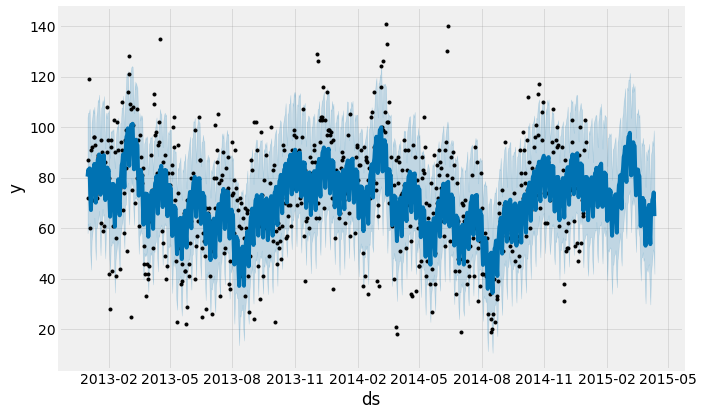

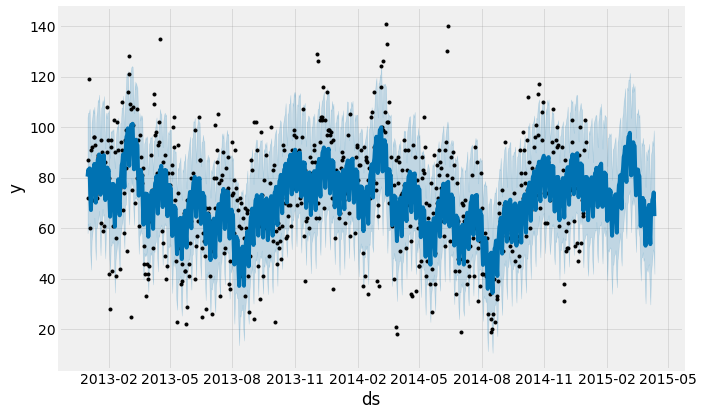

In [746]:
m.plot(forecast, uncertainty=True)

In [693]:
forecast

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2013-01-05,95.867381,95.867381,95.867381,62.823557,121.970350,-2.836048,-2.836048,-2.836048,-2.836048,-2.836048,-2.836048,-10.546952,-10.546952,-10.546952,7.710904,7.710904,7.710904,93.031333
1,2013-01-06,95.853417,95.853417,95.853417,51.440706,116.455845,-11.249040,-11.249040,-11.249040,-11.249040,-11.249040,-11.249040,-18.207930,-18.207930,-18.207930,6.958890,6.958890,6.958890,84.604377
2,2013-01-07,95.839453,95.839453,95.839453,72.716920,136.179543,7.781656,7.781656,7.781656,7.781656,7.781656,7.781656,1.575393,1.575393,1.575393,6.206263,6.206263,6.206263,103.621110
3,2013-01-08,95.825489,95.825489,95.825489,73.296413,136.805081,9.041428,9.041428,9.041428,9.041428,9.041428,9.041428,3.584003,3.584003,3.584003,5.457424,5.457424,5.457424,104.866917
4,2013-01-09,95.811525,95.811525,95.811525,76.279730,140.752109,12.677933,12.677933,12.677933,12.677933,12.677933,12.677933,7.961523,7.961523,7.961523,4.716410,4.716410,4.716410,108.489459
5,2013-01-10,95.797561,95.797561,95.797561,77.024928,143.533413,12.495904,12.495904,12.495904,12.495904,12.495904,12.495904,8.509027,8.509027,8.509027,3.986877,3.986877,3.986877,108.293465
6,2013-01-11,95.783598,95.783598,95.783598,72.954506,138.216739,10.397026,10.397026,10.397026,10.397026,10.397026,10.397026,7.124936,7.124936,7.124936,3.272090,3.272090,3.272090,106.180624
7,2013-01-12,95.769634,95.769634,95.769634,54.101516,119.625449,-7.972020,-7.972020,-7.972020,-7.972020,-7.972020,-7.972020,-10.546952,-10.546952,-10.546952,2.574932,2.574932,2.574932,87.797613
8,2013-01-13,95.755670,95.755670,95.755670,45.430106,111.162413,-16.310012,-16.310012,-16.310012,-16.310012,-16.310012,-16.310012,-18.207930,-18.207930,-18.207930,1.897918,1.897918,1.897918,79.445658
9,2013-01-14,95.741706,95.741706,95.741706,65.801719,130.099085,2.818621,2.818621,2.818621,2.818621,2.818621,2.818621,1.575393,1.575393,1.575393,1.243228,1.243228,1.243228,98.560326
